# Using the ml4qc package for a specific example analysis ("CAPI1")

This workbook demonstrates an example analysis for a particular CAPI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CAPI1".

This project is designed to explore the potential for ML-based tools to use only non-PII interview profiles (features constructed only from interview metadata and paradata) to identify outliers and submissions that are likely to be rejected by a human reviewer. It also explores use of ML techniques to explore interviewer effects.

In this case here, the survey team collected some but not all possible metadata, and every submission was reviewed for quality control purposes. Too few submissions were rejected to predict rejection, so instead we predict "not approved as GOOD quality" with a base rate of 70% (resting almost completely on the distinction between a "GOOD" and an "OKAY" quality rating). None of the models appear able to predict this outcome, and it's not clear whether a larger sample size would help. The quality ratings appear effectively random with respect to the metadata available. We'd need to look more closely to see whether there was sufficient inter-rater reliability in the quality ratings, what the rating protocols were, and whether more metadata or paradata would reasonably help.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **Surveyor_ID** - ID of enumerator who conducted the interview
* **mean_light_level** - Mean light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **sd_light_level** - Standard deviation of light level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 3/4 of submissions are missing data for this field)
* **mean_movement** - Mean device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **sd_movement** - Standard deviation of device movement during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html)) (unfortunately, 2/3 of submissions are missing data for this field)
* **mean_movement** - Mean sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **sd_movement** - Standard deviation of sound level during interview ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_quiet** - Percent of form-editing time when it was quiet ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **pct_still** - Percent of form-editing time when the device was still ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **duration** - Total number of seconds spent editing form
* **TA** - Name of text audit `.csv` file
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/capi1/capi1.csv"), attachments_available=True)

# initialize location for outputs
output_path_prefix = "~/ml4qc-data/collab1/capi1/"

# initialize enumerator ID column name
enumerator_id_column = "Surveyor_ID"

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      824
starttime           824
endtime             824
Surveyor_ID         824
mean_light_level    198
sd_light_level      198
mean_movement       297
sd_movement         297
mean_sound_level    824
sd_sound_level      824
pct_quiet           824
pct_still           824
duration            824
TA                  824
review_status       824
review_quality      824
dtype: int64

Submission DataFrame review status and quality:
APPROVED    819
REJECTED      5
Name: review_status, dtype: Int64
OKAY    572
GOOD    247
POOR      5
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         76147
duration_s    76147
visited_s     76147
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                                        824
starttime                                                                                             824
endtime                    

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using "submissions that are not APPROVED as GOOD quality" (i.e., rejected or another quality) as the target.

Here, we use PCA to reduce our feature dimensions, targeting 99% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [3]:
from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.99

# random state for reproducible results (or None)
random_state = 411

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "duration", "TA", "mean_light_level", "sd_light_level", "mean_movement", "sd_movement"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
class_columns = ["review_status", "review_quality", enumerator_id_column]
classes_df = analysis_df.loc[:, class_columns]
features_df = analysis_df.drop(class_columns, axis=1)

# set our target for prediction
target_description = "Not APPROVED+GOOD"
classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped 0/824 observations with missing data, for a loss of 0.00%

Target description: Not APPROVED+GOOD
1    577
0    247
Name: target, dtype: int64

Target base rate: 70.02%

numeric features: 1183
numeric_binary features: 442
numeric_unit_interval features: 730
numeric_other features: 11
datetime features: 0
other features: 2
  Starting training set shape: (618, 1185)
Starting prediction set shape: (206, 1185)
     Final training set shape: (618, 238)
   Final prediction set shape: (206, 238)


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [31]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser(output_path_prefix + "outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 26 (3.1553398058252426%)
CPU times: user 288 ms, sys: 51.9 ms, total: 340 ms
Wall time: 346 ms


target,0,1
is_outlier,,
0,0.967611,0.968804
1,0.032389,0.031196


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Logistic regression
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.21040733412812604
Parameters: {'C': 0.0001264961287093783, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

      Training set: (618, 238) (433 positive)
    Prediction set: (206, 238)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.7221042052739695

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classific

          Train accuracy:  35.92%
         Train precision:  100.00%
               Train F-1:  0.16
     Train ROC_AUC Score:  0.54
     Prediction accuracy:  33.98%
    Prediction precision:  100.00%
          Prediction F-1:  0.11
      Test ROC_AUC Score:  0.53


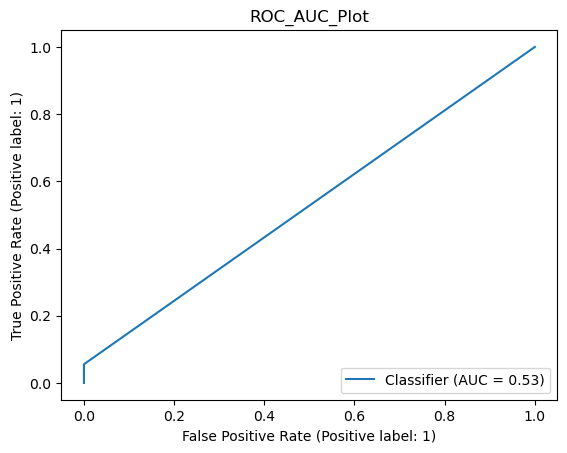

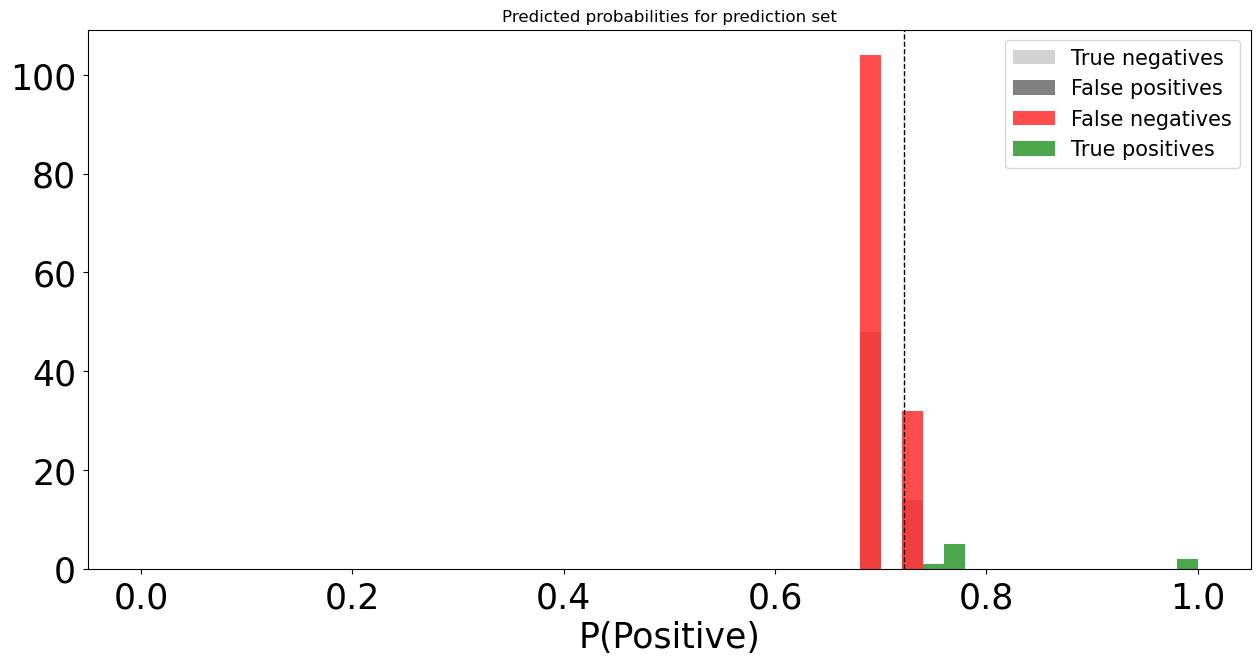

Test P(1) =  69.90%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  68.69%

              precision    recall  f1-score   support

           0       0.31      1.00      0.48        62
           1       1.00      0.06      0.11       144

    accuracy                           0.34       206
   macro avg       0.66      0.53      0.29       206
weighted avg       0.79      0.34      0.22       206



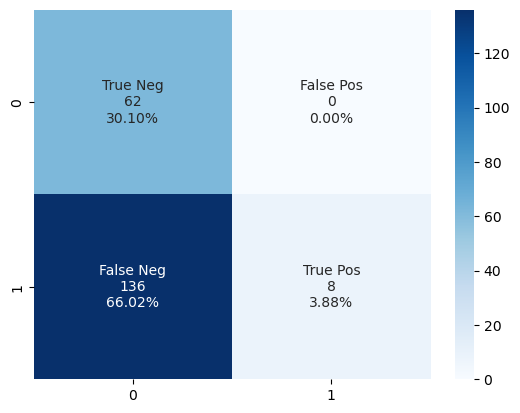

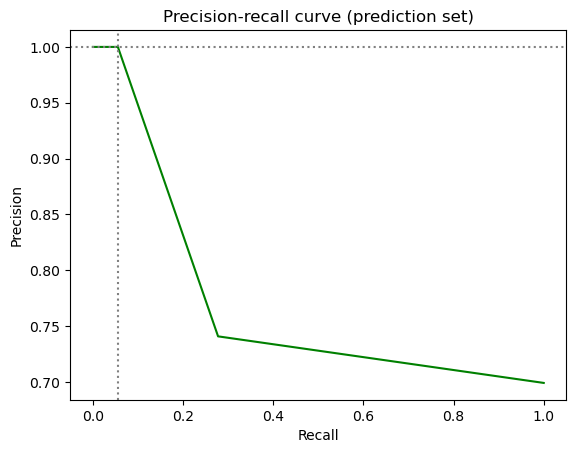

Cross validation results: 

fit_time: 0.025260003407796223 (SD: 0.003055130796837722)
score_time: 0.002413479487101237 (SD: 0.0004199202919170953)
test_accuracy: 0.33115656963021245 (SD: 0.04109821895114665)
test_precision: 0.5271047788025717 (SD: 0.3964068824693582)
test_f1: 0.12001558515557122 (SD: 0.14775055228146722)
test_roc_auc: 0.49268550828294216 (SD: 0.02872475779137344)
test_neg_log_loss: -0.6134416611739194 (SD: 0.006020693465527707)
test_neg_brier_score: -0.21089335433611162 (SD: 0.0020991112060712237)

Predictions made: 206
CPU times: user 897 ms, sys: 270 ms, total: 1.17 s
Wall time: 23.7 s


In [32]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Decision tree
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.2185537419633693
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 2, 'class_weight': None}

Running prediction model...

      Training set: (618, 238) (433 positive)
    Prediction set: (206, 238)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.6447264818005546

Fitting model...

Cross-validating model on training set...

          Train accuracy:  70.06%
         Train precision:  70.06%
               Train F-1:  0.82
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  69.90%
    Prediction precision:  69.90%
          Prediction F-1:  0.82
      Test ROC_AUC Score:  0.5

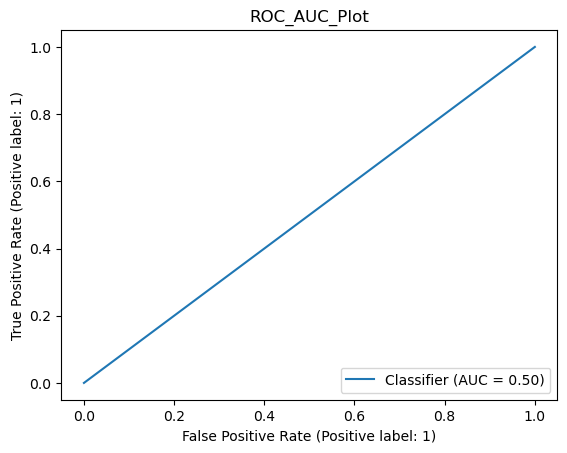

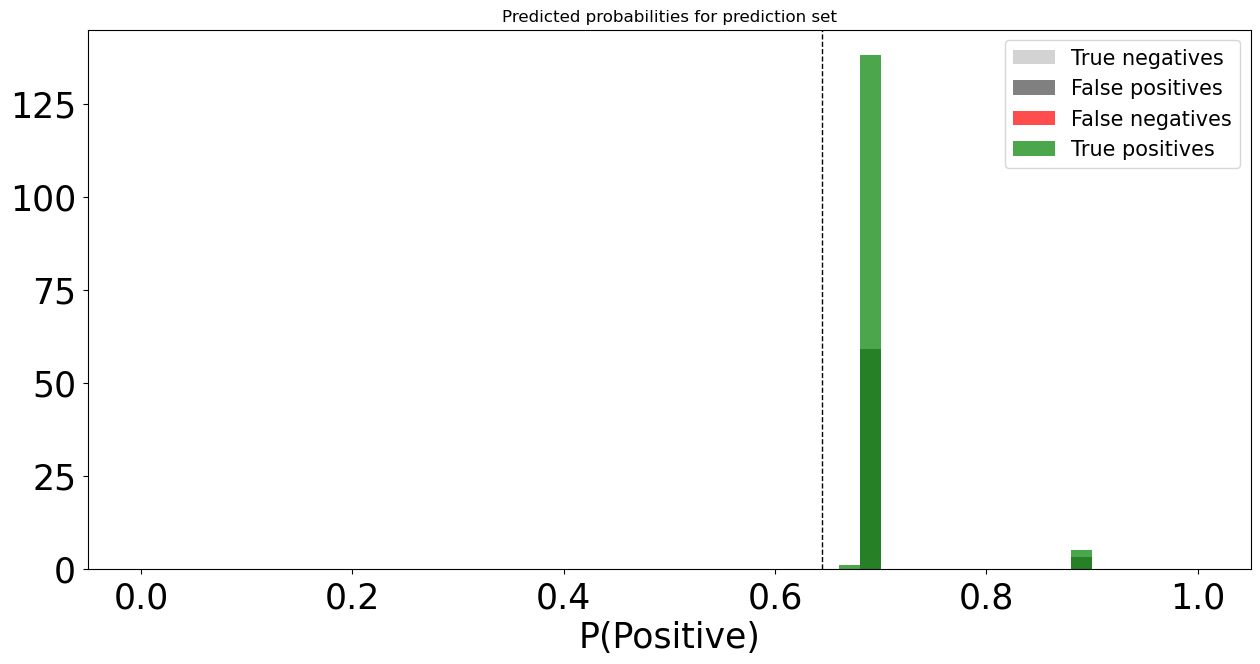

Test P(1) =  69.90%
Test P(1 | predicted 1) =  69.90%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.70      1.00      0.82       144

    accuracy                           0.70       206
   macro avg       0.35      0.50      0.41       206
weighted avg       0.49      0.70      0.58       206



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:407: RuntimeWarning: invalid value encountered in long_scalars
  """
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being 

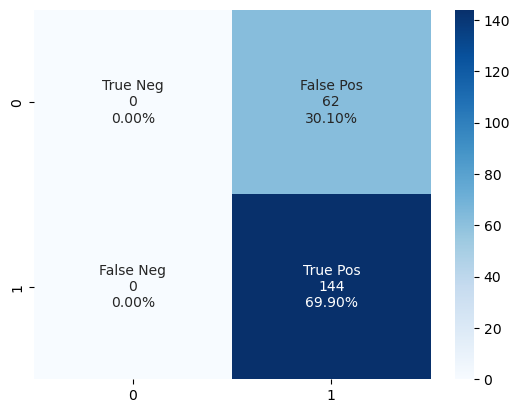

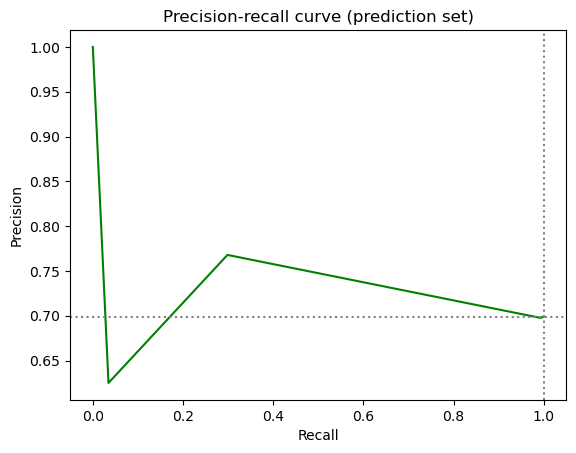

Cross validation results: 

fit_time: 0.010900274912516276 (SD: 0.0016987043634227974)
score_time: 0.0021137396494547525 (SD: 0.0001534273892620662)
test_accuracy: 0.6968659847888802 (SD: 0.0072869939334508855)
test_precision: 0.7003715088553363 (SD: 0.0016885252067122998)
test_f1: 0.8208486490661631 (SD: 0.005911055498846434)
test_roc_auc: 0.5160907499319688 (SD: 0.028103774125439095)
test_neg_log_loss: -0.6860868890959448 (SD: 0.2849261803751231)
test_neg_brier_score: -0.21111381592400408 (SD: 0.00571182540534406)

Predictions made: 206
CPU times: user 696 ms, sys: 101 ms, total: 797 ms
Wall time: 7.19 s


In [33]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Random forest
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.20913062582275393
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 2, 'class_weight': None, 'bootstrap': True}

Running prediction model...

      Training set: (618, 238) (433 positive)
    Prediction set: (206, 238)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.6335595706034385

Fitting model...

Cross-validating model on training set...

          Train accuracy:  70.06%
         Train precision:  70.06%
               Train F-1:  0.82
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  69.90%
    Prediction precision:  69.90%
          Prediction F-1:  0.82
      Test

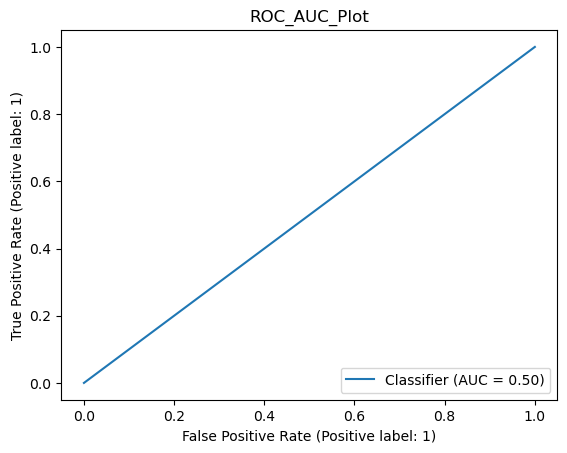

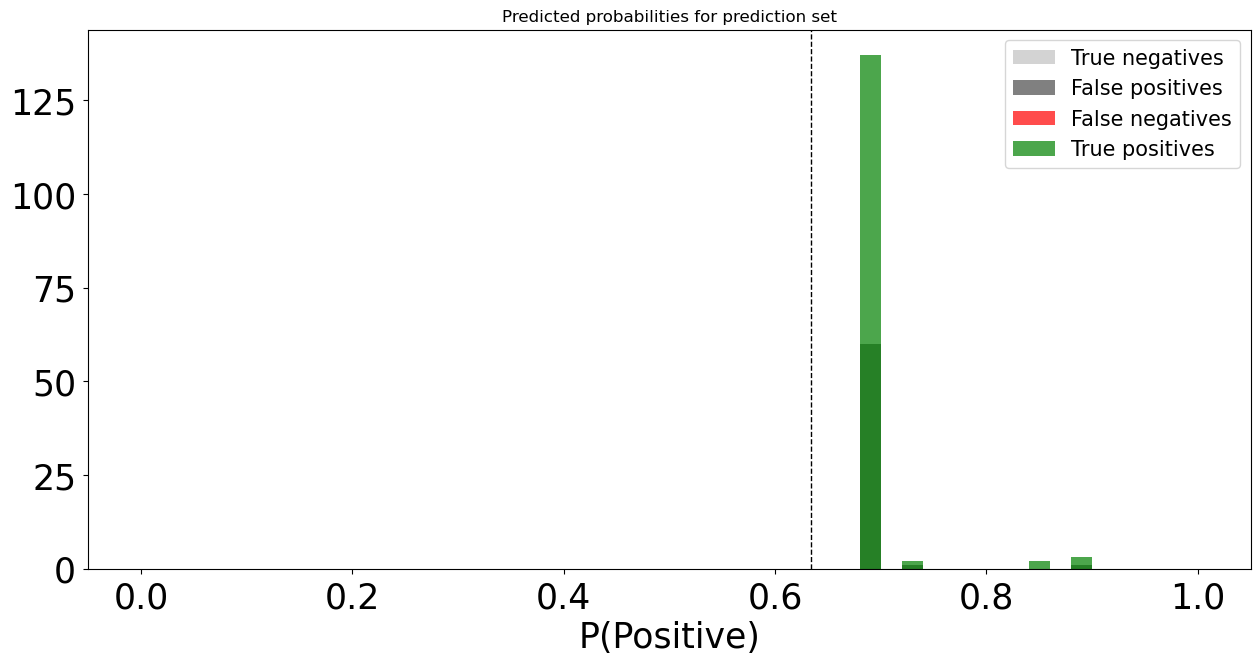

Test P(1) =  69.90%
Test P(1 | predicted 1) =  69.90%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.70      1.00      0.82       144

    accuracy                           0.70       206
   macro avg       0.35      0.50      0.41       206
weighted avg       0.49      0.70      0.58       206



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:407: RuntimeWarning: invalid value encountered in long_scalars
  """
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being 

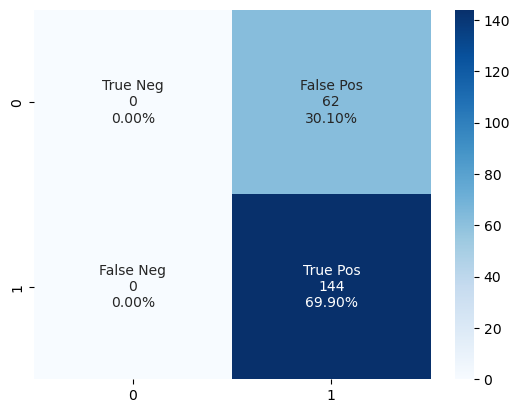

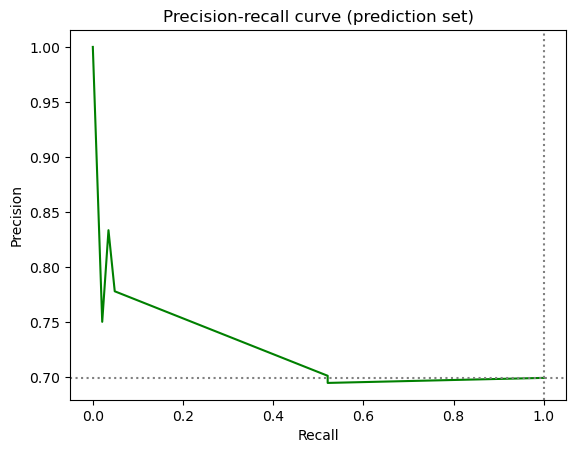

Cross validation results: 

fit_time: 3.450315300623576 (SD: 0.3082164033670316)
score_time: 0.046768871943155925 (SD: 0.0022295848123896293)
test_accuracy: 0.6947285601888277 (SD: 0.019820992322308776)
test_precision: 0.6996075205706344 (SD: 0.005066531213182745)
test_f1: 0.819155034546195 (SD: 0.01552825592224782)
test_roc_auc: 0.5167519163108578 (SD: 0.029669716338563534)
test_neg_log_loss: -0.6490476239243692 (SD: 0.09412353295815483)
test_neg_brier_score: -0.2108912927961722 (SD: 0.002993462108543149)

Predictions made: 206
CPU times: user 6.7 s, sys: 376 ms, total: 7.08 s
Wall time: 1min 23s


In [34]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: XGBoost
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 54 candidates, totalling 810 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best neg_brier_score: -0.23006118710275822
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 2, 'max_depth': 2}

Running prediction model...

      Training set: (618, 238) (433 positive)
    Prediction set: (206, 238)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.5013139933347702

Fitting model...

Cross-validating model on training set...

          Train accuracy:  91.75%
         Train precision:  89.46%
               Train F-1:  0.94
     Train ROC_AUC Score:  0.86
     Prediction accuracy:  68.93%
    Prediction precision:  69.80%
          Prediction F-1:  0.82
      Test ROC_AUC Score:  0.5


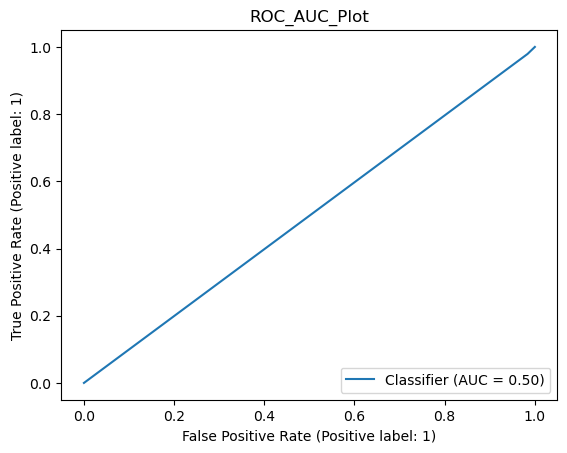

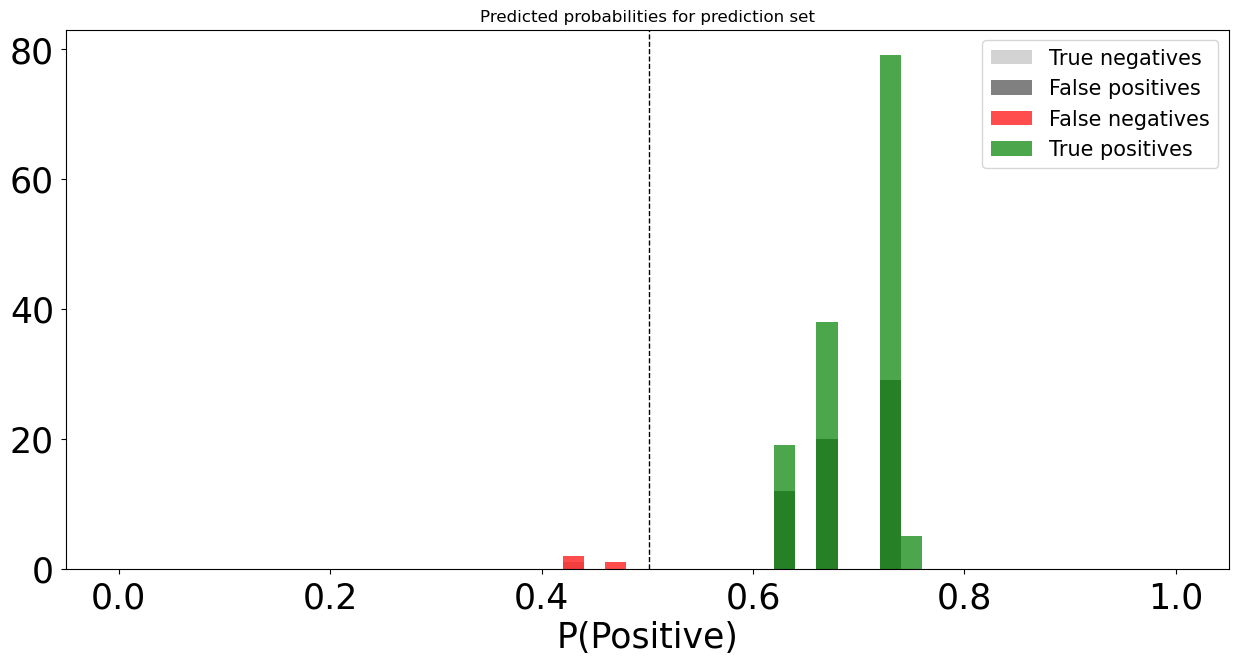

Test P(1) =  69.90%
Test P(1 | predicted 1) =  69.80%
Test P(1 | predicted 0) =  75.00%

              precision    recall  f1-score   support

           0       0.25      0.02      0.03        62
           1       0.70      0.98      0.82       144

    accuracy                           0.69       206
   macro avg       0.47      0.50      0.42       206
weighted avg       0.56      0.69      0.58       206



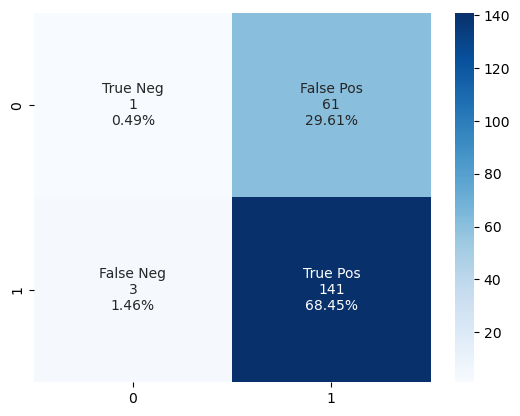

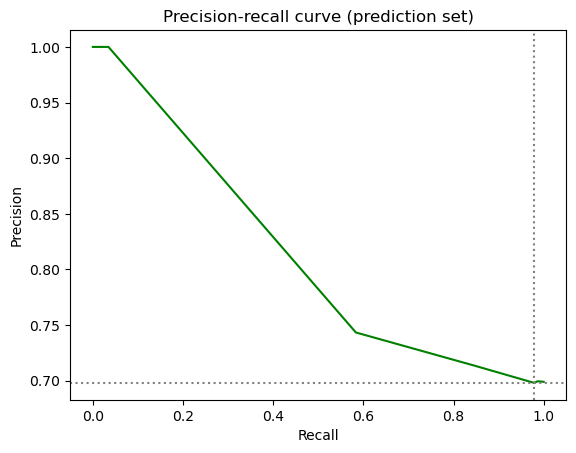

Cross validation results: 

fit_time: 4.765817356109619 (SD: 0.7422544000464604)
score_time: 0.005827601750691732 (SD: 0.005705615875097582)
test_accuracy: 0.7001049042748491 (SD: 0.003617629279741937)
test_precision: 0.7015871319649515 (SD: 0.0029563369443748725)
test_f1: 0.8230370812535399 (SD: 0.0023088877660139184)
test_roc_auc: 0.5372673395127284 (SD: 0.028166092569430926)
test_neg_log_loss: -0.7221877612351101 (SD: 0.2526069208327508)
test_neg_brier_score: -0.21120503998711654 (SD: 0.006453038133575284)

Predictions made: 206
CPU times: user 10.9 s, sys: 3.64 s, total: 14.5 s
Wall time: 54.6 s


In [35]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Neural network
     Scoring: neg_brier_score

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_27 (Dropout)        (None, 238)               0         
                                                                 
 dense_27 (Dense)            (None, 238)               56882     
                                                                 
 dropout_28 (Dropout)        (None, 238)               0         
                                                                 
 dense_28 (Dense)            (None, 119)               28441     
                                                                 
 dropout_29 (Dropout)        (None, 119)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 120       
                            

2023-01-05 16:51:32.750437: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:32.763201: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:32.773114: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:32.782193: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:32.788021: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:33.780213: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:37.467656: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:51:38.421317: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   Final threshold: 0.5290154248476029

Fitting model...



Cross-validating model on training set...



          Train accuracy:  70.06%
         Train precision:  70.06%
               Train F-1:  0.82
     Train ROC_AUC Score:  0.5
     Prediction accuracy:  69.90%
    Prediction precision:  69.90%
          Prediction F-1:  0.82
      Test ROC_AUC Score:  0.5


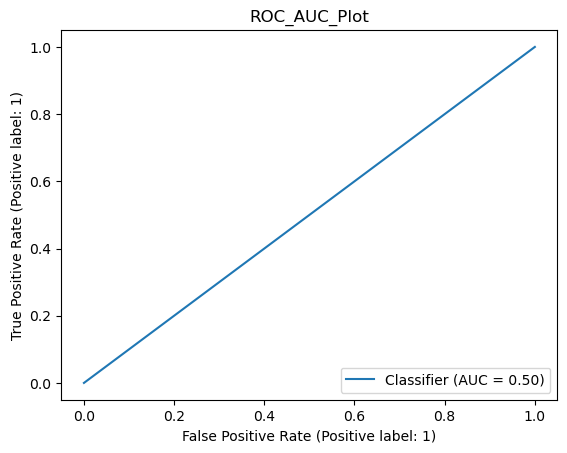

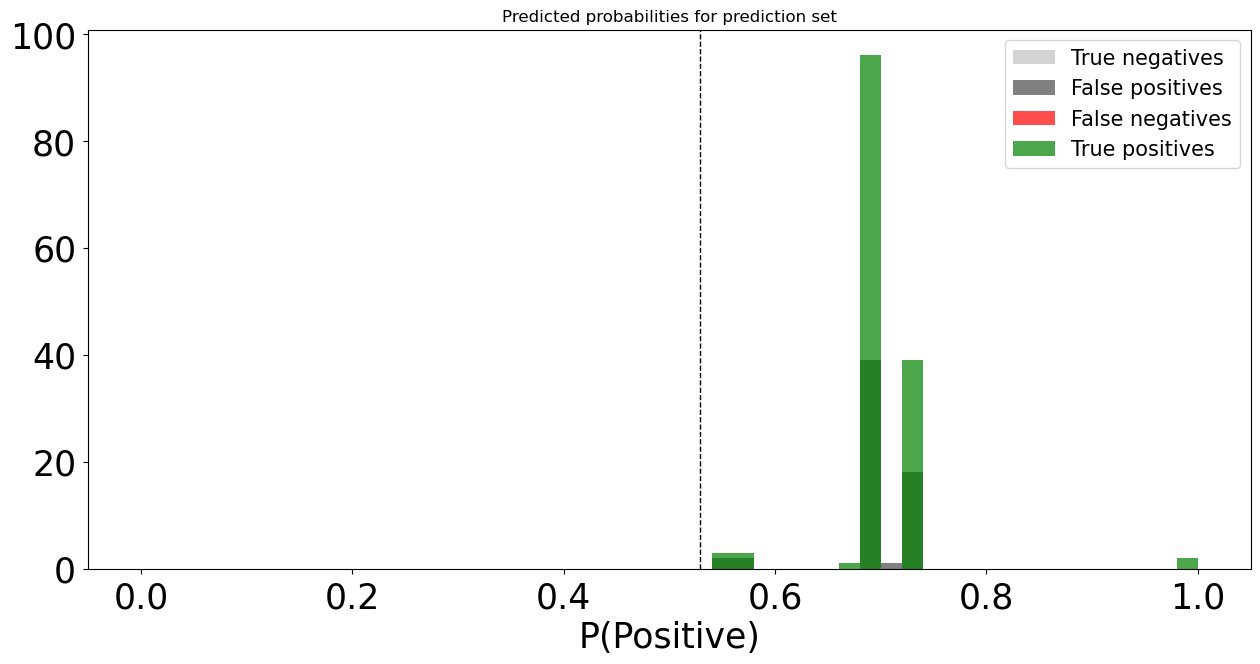

Test P(1) =  69.90%
Test P(1 | predicted 1) =  69.90%
Test P(1 | predicted 0) =  nan%

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.70      1.00      0.82       144

    accuracy                           0.70       206
   macro avg       0.35      0.50      0.41       206
weighted avg       0.49      0.70      0.58       206



/Users/crobert/Code/Orange Chair Labs/ml4qc/src/ml4qc/surveymlclassifier.py:407: RuntimeWarning: invalid value encountered in long_scalars
  """
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being 

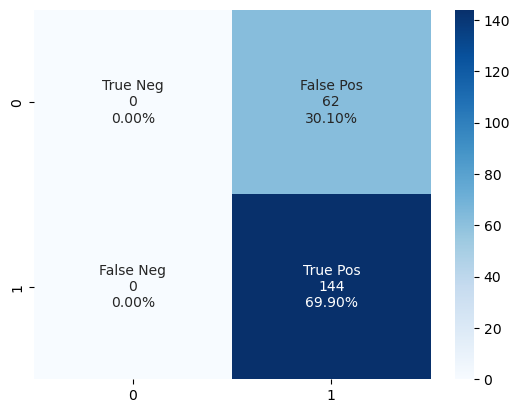

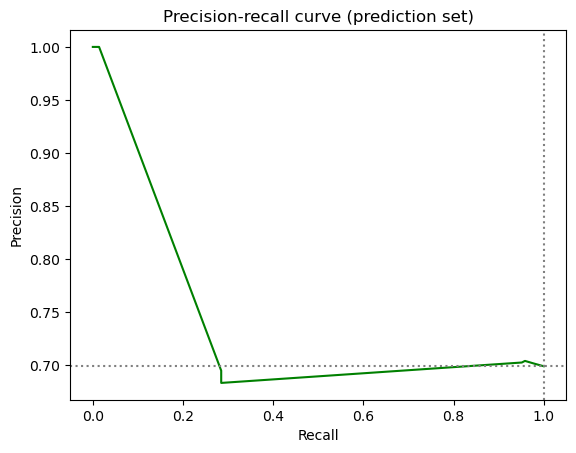

Cross validation results: 

fit_time: 4.9708307902018225 (SD: 0.4928521788916165)
score_time: 0.10624558130900065 (SD: 0.021552382845366133)
test_accuracy: 0.6952574525745258 (SD: 0.010720108539961972)
test_precision: 0.6992028833593674 (SD: 0.0027499426117414986)
test_f1: 0.8200570955103309 (SD: 0.007993503745102198)
test_roc_auc: 0.521171652807579 (SD: 0.0397657342035912)
test_neg_log_loss: -0.6535529462727901 (SD: 0.09756880274079742)
test_neg_brier_score: -0.212401611885682 (SD: 0.0037108862134750537)

Predictions made: 206
CPU times: user 6.26 s, sys: 879 ms, total: 7.14 s
Wall time: 26.6 s


In [36]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from scikeras.wrappers import KerasClassifier

# # Option 1: use cross validation to find the optimal hyperparameters
# import numpy as np
# import sklearn as skl
# classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
# #   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
# search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
# params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -0.21053700100265074
# Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 10, 'model__activation': 'sigmoid', 'model__dropout_rate': 0.5, 'model__features': 238, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': 238, 'model__l2_factor': 0.0003799316823249954, 'model__l2_regularization': True, 'model__output_bias': None}
params = {'batch_size': 32, 'class_weight': None, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__include_dropout': True, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.0003799316823249954, 'model__l2_regularization': True, 'model__output_bias': None}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")

### Enumerator analysis

The following analyses seek to take the interview profiles used for the analysis above, and consider empirical enumerator effects and relationships.

In [4]:
# summarize interview counts by enumerator ID
print(classes_df[enumerator_id_column].value_counts())

FR0008    126
FR0004    118
FR0006    114
FR0005     99
FR0007     85
FR0011     75
FR0003     68
FR0002     65
FR0001     41
FR0009     30
FR0010      3
Name: Surveyor_ID, dtype: Int64


#### Cluster analysis

This first approach seeks to identify natural clusters of interview profiles, and tests to see whether clusters and enumerators are statistically independent. The clusters are saved to disk, and the p value is reported for a single chi-squared test of independence.

In this case, there are a number of single-interview clusters even after separating outliers, so we force clusters to be no less than 1/2 the average size and no more than 2x the average size. The enumerator and cluster distributions are not at all independent (p < 0.0000001).

In [6]:
# identify clusters
clusters_df = surveyml.identify_clusters(min_clusters=2, max_clusters=10, separate_outliers=True, constrain_cluster_size=True)

# add enumerator ID's and save to disk
clusters_df[enumerator_id_column] = classes_df[enumerator_id_column]
clusters_df.to_csv(os.path.expanduser(output_path_prefix + "interview_clusters.csv"))

print()
print(f"Final clusters saved to disk:")
print(clusters_df.cluster.value_counts())
print()

# test for independence of cluster and enumerator
from scipy.stats import chi2_contingency
cluster_by_enum = pd.crosstab(clusters_df["cluster"], clusters_df[enumerator_id_column])
test_stat, pvalue, dof, expected_freq = chi2_contingency(cluster_by_enum)

print(f"p value for chi-squared against null that enumerator and cluster are unrelated: {pvalue}")

Identifying outliers...
Outliers: 26 (3.1553398058252426%)
26 outliers detected, will be put in separate cluster (-1).

  Starting features shape: (798, 1185)
     Final features shape: (798, 1206)

Choosing best silhouette coefficient for n_clusters between 2 and 10...

Silhouette coefficient for 2 clusters: 0.34115287958693963
1    455
0    343
Name: 0, dtype: int64

Silhouette coefficient for 3 clusters: 0.34025802312415454
0    343
2    241
1    214
Name: 0, dtype: int64

Silhouette coefficient for 4 clusters: 0.3459198092763818
1    343
3    240
0    116
2     99
Name: 0, dtype: int64

Silhouette coefficient for 5 clusters: 0.12691755970329796
1    251
2    239
3    135
4     92
0     81
Name: 0, dtype: int64

Silhouette coefficient for 6 clusters: 0.13084615258113674
4    266
2    194
3    129
1     77
5     66
0     66
Name: 0, dtype: int64

Silhouette coefficient for 7 clusters: 0.06690162579488824
1    228
3    141
2    118
5    115
4     82
6     57
0     57
Name: 0, dtype: i

#### Benchmarking against star enumerators

This next approach takes a list of known "star" enumerators (enumerators known to follow interview protocols and, in general, conduct excellent interviews) and benchmarks all interviews against those enumerators' interviews. A logistic regression classification approach is used to calculate the probability that each interview was conducted by a star enumerator. Each enumerator's average probability is then treated as a score and output to disk. Obviously, star enumerators will be scored most highly by construction.

Here, because interviewer effects seem to be strong (particularly for the single enumerator being benchmarked against), a powerful L2 regularization constant is used to generalize the model and provide for more variations in score.

In [7]:
# list star enumerators to benchmark against
star_enumerators = ["FR0008"]

# benchmark against our star enumerators
benchmark_df = surveyml.benchmark_by_category(category_df=pd.DataFrame(classes_df[enumerator_id_column]), benchmark_categories=star_enumerators, method="logistic", reg_strength=0.001, variance_to_retain=1.0)

# save results to .csv
print(f"Benchmarking against the following enumerators saved to disk: {star_enumerators}")
benchmark_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_benchmarks.csv"))

0    698
1    126
Name: is_benchmark, dtype: int64

Target base rate: 15.29%

  Starting features shape: (824, 1185)
     Final features shape: (824, 1206)

Fitting model...

Benchmarking against the following enumerators saved to disk: ['FR0008']


#### Investigate enumerator similarities

This next approach uses a K-nearest-neighbor approach to predict which enumerator conducted each interview, based on which interview profiles are nearest, by weighted distance, to which others. The predictions are then summarized and output to disk, in crosstabs with count and row-wise-percentages, and in a high-level summary with the following columns:

* Enumerator ID [however it's named in source data]: the enumerator ID
* `self_similarity_score`: percentage of time an enumerator's interviews were correctly predicted to be conducted by them
* `most_like_self`: 1 for cases where the enumerator's interviews were most often classified as being conducted by them, otherwise 0
* `most_like`: most frequent enumerator predicted for the enumerator's interviews
* `most_like_score`: percentage of interviews predicted to be conducted by the "most_like" enumerator
* `second_most_like`: second-most-frequent enumerator predicted for the enumerator's interviews
* `second_most_like_score`: percentage of interviews predicted to be conducted by the "second_most_like" enumerator

If you randomly assign interviews to enumerators, you generally won't want to see strong enumerator effects. Ideally, you'd see low `self_similarity_score`s and "most_like" scores that suggest that it's hard to tell which enumerator conducted which interview. In fact, you'd ideally find interview profiles to be essentially random with respect to enumerator.

Here, essentially all enumerators are "most like" themselves, which is a bad sign if enumerators were randomly assigned to interviews. (The only enumerator not most like themselves had only three interviews, so the nearest-neighbors approach wouldn't have identified them as a prediction.)

Finally, the p value for the chi-squared test of enumerator-predicted-enumerator independence is reported, with p at essentially 0.0. So clearly there are significant enumerator effects.

In [8]:
# predict the enumerator for each interview
enum_df = surveyml.classify_by_category(category_df=pd.DataFrame(classes_df[enumerator_id_column]), method="knn")

# test for independence of enumerator and predicted enumerator
from scipy.stats import chi2_contingency
enum_by_predicted = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"])
enum_by_predicted_pct = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"], normalize='index')
test_stat, pvalue, dof, expected_freq = chi2_contingency(enum_by_predicted)

print(f"p value for chi-squared against null that enumerator and predicted enumerator are unrelated: {pvalue}")
print()

# ensure all enumerators included in second dimension of crosstab, even if all 0's
for column in enum_by_predicted.index.values:
    if not column in enum_by_predicted.columns.values:
        enum_by_predicted[column] = 0
        enum_by_predicted_pct[column] = 0.0
enum_by_predicted = enum_by_predicted.reindex(sorted(enum_by_predicted.columns), axis=1)
enum_by_predicted_pct = enum_by_predicted_pct.reindex(sorted(enum_by_predicted_pct.columns), axis=1)

# create DataFrame with summary of empirical enumerator relationships
enum_relationship_df = pd.DataFrame(index=enum_by_predicted.index)
enum_relationship_df['most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -1]]
enum_relationship_df['second_most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -2]]
for index in enum_by_predicted_pct.index.values:
    enum_relationship_df.loc[index, "most_like_self"] = 1 if enum_relationship_df.loc[index, "most_like"] == index else 0
    enum_relationship_df.loc[index, "self_similarity_score"] = enum_by_predicted_pct.loc[index, index]
    enum_relationship_df.loc[index, "most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "most_like"]]
    enum_relationship_df.loc[index, "second_most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "second_most_like"]]
enum_relationship_df = enum_relationship_df[['self_similarity_score', 'most_like_self', 'most_like', 'most_like_score', 'second_most_like', 'second_most_like_score']]

# save results to .csv
print(f"Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk")
enum_by_predicted.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab.csv"))
enum_by_predicted_pct.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab_pct.csv"))
enum_relationship_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_relationship_summary.csv"))

  Starting features shape: (824, 1185)
     Final features shape: (824, 1206)

Fitting model...

p value for chi-squared against null that enumerator and predicted enumerator are unrelated: 0.0

Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk
